# **Personalized Offers and Rewards recommendation for GPay Users**


This project aims to develop a machine learning-based personalized rewards and offers system for GPay users.

The system analyzes transaction history, spending patterns, and user engagement to predict and recommend tailored offers, improving user engagement and merchant satisfaction.

Engineered features, built predictive models,

and optimized accuracy using hyperparameter tuning. Deploy the model

The proposed solution uses advanced data analytics and machine learning models to provide recommendations that align with user preferences and spending habits. By understanding user behavior, the system can deliver the right offers at the right time, increasing offer redemption rates and overall user satisfaction.

##  Last_Offer_Redeemed as a target variable

Supervise Learning -- if we have labelled data with past offers and user responses

In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df = pd.read_csv("/content/bank_transactions_data.csv")
df.shape

(2000, 14)

In [3]:
print(df.head())
print(df.info())

  TransactionID AccountID  CustomerAge  gender  TransactionAmount  \
0      TX000001   AC00128           70  Female              14.09   
1      TX000002   AC00455           68    Male             376.24   
2      TX000003   AC00019           19  Female             126.29   
3      TX000004   AC00070           26  Female             184.50   
4      TX000005   AC00411           26    Male              13.45   

    TransactionDate TransactionType location MerchantID Channel  \
0  11-04-2023 16:29           Debit   Mumbai       M015     ATM   
1  27-06-2023 16:44           Debit  Chennai       M052     ATM   
2  10-07-2023 18:16           Debit     Pune       M009  Online   
3  05-05-2023 16:32           Debit     Pune       M002  Online   
4  16-10-2023 17:51          Credit  Chennai       M091  Online   

  PreviousTransactionDate  offer_accepted offer_type_last_given  \
0        04-11-2024 08:08               1        Loyalty Points   
1        04-11-2024 08:09               0       

#Step1:Data Preprocessing

In [4]:
df.isnull().sum()

,0
TransactionID,0
AccountID,0
CustomerAge,0
gender,0
TransactionAmount,0
TransactionDate,0
TransactionType,0
location,0
MerchantID,0
Channel,0


In [5]:
df["TransactionDate"] = pd.to_datetime(df["TransactionDate"], format="%d-%m-%Y %H:%M")
df["PreviousTransactionDate"] = pd.to_datetime(df["PreviousTransactionDate"], format="%d-%m-%Y %H:%M")

df = df.rename(columns={'TransactionDate':'PreviousTransactionDate', 'PreviousTransactionDate': 'Latest_TransationDate'})
df = df.drop(['gender', 'CustomerAge'], axis=1)

#Step2: Feature Engg

In [6]:
# Compute time difference (days since last transaction)
df["DaysSinceLastTransaction"] = (df["Latest_TransationDate"] - df["PreviousTransactionDate"]).dt.days
df.columns



Index(['TransactionID', 'AccountID', 'TransactionAmount',
       'PreviousTransactionDate', 'TransactionType', 'location', 'MerchantID',
       'Channel', 'Latest_TransationDate', 'offer_accepted',
       'offer_type_last_given', 'transaction_category_last',
       'DaysSinceLastTransaction'],
      dtype='object')

In [7]:
# Aggregate user features
user_features = df.groupby("AccountID").agg(
    MostFrequentCategory=("transaction_category_last", lambda x: x.mode()[0] if not x.mode().empty else "Unknown"),
    MostFrequentMerchant=("MerchantID", lambda x: x.mode()[0] if not x.mode().empty else "Unknown"),
    AvgDaysBetweenTransactions=("DaysSinceLastTransaction", "mean")
).reset_index()

# Merge back with original dataset
df = df.merge(user_features, on="AccountID", how="left")
df.head()
df.columns

# Aggregate user spending behavior
spending_features = df.groupby("AccountID").agg(
    TotalSpend=("TransactionAmount", "sum"),
    AvgTransactionAmount=("TransactionAmount", "mean"),
    TransactionCount=("TransactionID", "count"),
).reset_index()

# Define spending categories based on quartiles
spending_features["SpendingCategory"] = pd.qcut(
    spending_features["TotalSpend"], q=4, labels=["Low", "Medium", "High", "Premium"]
)
# Merge back with main dataframe
df = df.merge(spending_features, on="AccountID", how="left")
df.head()
df.columns

Index(['TransactionID', 'AccountID', 'TransactionAmount',
       'PreviousTransactionDate', 'TransactionType', 'location', 'MerchantID',
       'Channel', 'Latest_TransationDate', 'offer_accepted',
       'offer_type_last_given', 'transaction_category_last',
       'DaysSinceLastTransaction', 'MostFrequentCategory',
       'MostFrequentMerchant', 'AvgDaysBetweenTransactions', 'TotalSpend',
       'AvgTransactionAmount', 'TransactionCount', 'SpendingCategory'],
      dtype='object')

In [8]:
# Encode categorical features
categorical_cols = ["MostFrequentCategory", "MostFrequentMerchant", "offer_type_last_given","SpendingCategory"]
label_encoders = {col: LabelEncoder() for col in categorical_cols}

for col in categorical_cols:
    df[col] = label_encoders[col].fit_transform(df[col])




In [9]:
# Select features and target variable
features = ["TransactionCount", "AvgTransactionAmount",
            "AvgDaysBetweenTransactions", "MostFrequentCategory",
            "MostFrequentMerchant", "offer_type_last_given","SpendingCategory"]

X = df[features]
y = df["offer_accepted"]



In [10]:
# Standardize numerical features & split train - test data
scaler = StandardScaler()
X[["TransactionCount", "AvgTransactionAmount",
   "AvgDaysBetweenTransactions"]] = scaler.fit_transform(
    X[["TransactionCount", "AvgTransactionAmount",
       "AvgDaysBetweenTransactions"]])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Display dataset shape
X_train.shape, X_test.shape


<ipython-input-10-13044cedb793>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[["TransactionCount", "AvgTransactionAmount",


((1600, 7), (400, 7))

#Step3: Model Selection

In [ ]:
"""
#Random forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf}")

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
"""

Random Forest Accuracy: 0.6225
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.74      0.73       277
           1       0.38      0.35      0.36       123

    accuracy                           0.62       400
   macro avg       0.55      0.55      0.55       400
weighted avg       0.61      0.62      0.62       400



In [11]:
#Model implementation - XGBoost Algorithm
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")



Accuracy: 0.63


#Step4: Hyperparameter Tunning

In [12]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 500],  # Number of trees
    'max_depth': [3, 5, 7, 10],  # Maximum depth of each tree
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Step size shrinkage
    'subsample': [0.6, 0.8, 1.0],  # Percentage of samples used per tree
    'colsample_bytree': [0.6, 0.8, 1.0],  # Percentage of features used per tree
    'gamma': [0, 0.1, 0.2, 0.3],  # Minimum loss reduction for split
    'reg_alpha': [0, 0.01, 0.1, 1],  # L1 regularization
    'reg_lambda': [0, 0.01, 0.1, 1]  # L2 regularization
}

In [13]:


# Initialize XGBoost model
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')





In [14]:
# RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=20,  # Number of combinations to try
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1,
    random_state=42
)


In [15]:
!pip install scikit-learn==1.3.0 xgboost --upgrade

In [16]:

# Fit the model
random_search.fit(X_train, y_train)

# Best parameters & best score
print("Best Hyperparameters:", random_search.best_params_)
print("Best Accuracy Score:", random_search.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [03:40:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Hyperparameters: {'subsample': 0.8, 'reg_lambda': 0, 'reg_alpha': 0.1, 'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.2, 'colsample_bytree': 0.6}
Best Accuracy Score: 0.6925000000000001


In [17]:


# Train final model with best parameters
best_xgb_model = random_search.best_estimator_

# Predict on test data
y_pred = best_xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Final Model Accuracy: {accuracy}")
print("Classification Report:\n", classification_report(y_test, y_pred))


Final Model Accuracy: 0.69
Classification Report:
               precision    recall  f1-score   support

           0       0.69      1.00      0.82       277
           1       0.00      0.00      0.00       123

    accuracy                           0.69       400
   macro avg       0.35      0.50      0.41       400
weighted avg       0.48      0.69      0.57       400



In [18]:
#Calculate confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[276   1]
 [123   0]]


=====================================

In [19]:

df.columns
df['MostFrequentCategory'].count()
df["MostFrequentCategory"].value_counts()


,count
MostFrequentCategory,
1,502
0,490
2,337
3,237
5,227
4,207


In [20]:
encoder = label_encoders['MostFrequentCategory']
mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print(mapping)

{'Entertainment': 0, 'Food': 1, 'Fuel': 2, 'Healthcare': 3, 'Shopping': 4, 'Travel': 5}


#offers recommendation

In [21]:
#offers recommendation
def recommend_offer(row):
 if row['SpendingCategory']==3 and row['MostFrequentCategory']==1:
     return "Loyalty Points"
 elif row['SpendingCategory']>=2 and row['MostFrequentCategory']==0:
     return "Cashback 10%"
 elif row['SpendingCategory']>=1 and row['MostFrequentCategory']==2:
     return "Discount 10%"
 elif row['SpendingCategory']==0 and row['MostFrequentCategory']==1:
     return "Freebie"
 else :
     return "BOGO"

# Generate target variable
df["predicted_offer"] = df.apply(recommend_offer, axis=1)

In [22]:
df

,TransactionID,AccountID,TransactionAmount,PreviousTransactionDate,TransactionType,location,MerchantID,Channel,Latest_TransationDate,offer_accepted,...,transaction_category_last,DaysSinceLastTransaction,MostFrequentCategory,MostFrequentMerchant,AvgDaysBetweenTransactions,TotalSpend,AvgTransactionAmount,TransactionCount,SpendingCategory,predicted_offer
0,TX000001,AC00128,14.09,2023-04-11 16:29:00,Debit,Mumbai,M015,ATM,2024-11-04 08:08:00,1,...,Food,572,3,14,557.833333,2798.98,466.496667,6,3,BOGO
1,TX000002,AC00455,376.24,2023-06-27 16:44:00,Debit,Chennai,M052,ATM,2024-11-04 08:09:00,0,...,Fuel,495,0,0,481.000000,2132.36,304.622857,7,3,Cashback 10%
2,TX000003,AC00019,126.29,2023-07-10 18:16:00,Debit,Pune,M009,Online,2024-11-04 08:07:00,1,...,Fuel,482,0,8,534.500000,167.42,83.710000,2,1,BOGO
3,TX000004,AC00070,184.50,2023-05-05 16:32:00,Debit,Pune,M002,Online,2024-11-04 08:09:00,1,...,Food,548,1,1,491.714286,1791.89,255.984286,7,3,Loyalty Points
4,TX000005,AC00411,13.45,2023-10-16 17:51:00,Credit,Chennai,M091,Online,2024-11-04 08:06:00,0,...,Fuel,384,1,38,451.333333,1684.78,280.796667,6,3,Loyalty Points
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,TX001996,AC00460,999.28,2023-05-22 17:45:00,Debit,Kolkata,M050,Online,2024-11-04 08:12:00,1,...,Shopping,531,4,62,521.888889,4849.31,538.812222,9,3,BOGO
1996,TX001997,AC00373,14.16,2023-01-09 16:49:00,Credit,Delhi,M076,Branch,2024-11-04 08:10:00,0,...,Travel,664,1,12,542.428571,1440.80,205.828571,7,0,Freebie
1997,TX001998,AC00021,1142.83,2023-07-14 17:44:00,Credit,Chennai,M028,Branch,2024-11-04 08:11:00,0,...,Shopping,478,0,27,474.000000,2349.19,469.838000,5,3,Cashback 10%
1998,TX001999,AC00235,61.33,2023-09-20 18:18:00,Debit,Kolkata,M018,ATM,2024-11-04 08:06:00,0,...,Healthcare,410,1,1,456.333333,807.43,134.571667,6,2,BOGO


#Step5: Data Visualization

Text(0.5, 1.0, 'User Spending Distribution (Transaction Amounts)')

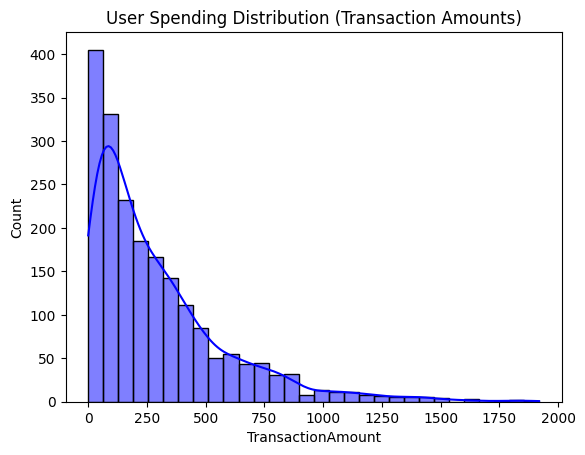

In [23]:
#Figure size setup
fig, ax = plt.subplots()

#1. User Spending Distribution
sns.histplot(df["TransactionAmount"], bins=30, kde=True,  color="blue")
ax.set_title("User Spending Distribution (Transaction Amounts)")



<ipython-input-24-7f8476438777>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["offer_accepted"], palette="coolwarm")


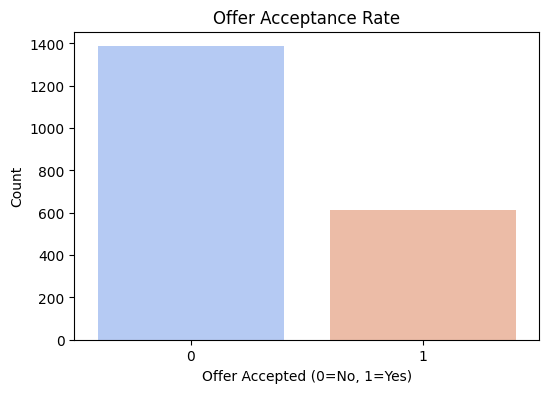

In [24]:


plt.figure(figsize=(6, 4))
sns.countplot(x=df["offer_accepted"], palette="coolwarm")
plt.title("Offer Acceptance Rate")
plt.xlabel("Offer Accepted (0=No, 1=Yes)")
plt.ylabel("Count")
plt.show()


<ipython-input-25-eb9b7b0867a1>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_counts.index, y=category_counts.values, palette="coolwarm")


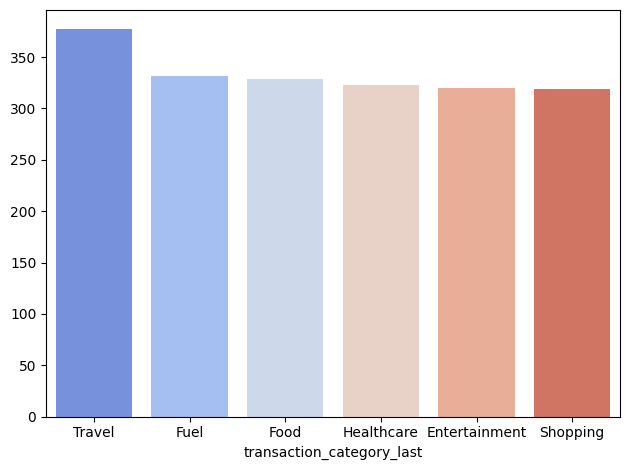

In [25]:
category_counts = df["transaction_category_last"].value_counts()
sns.barplot(x=category_counts.index, y=category_counts.values, palette="coolwarm")
plt.tight_layout()
plt.show()



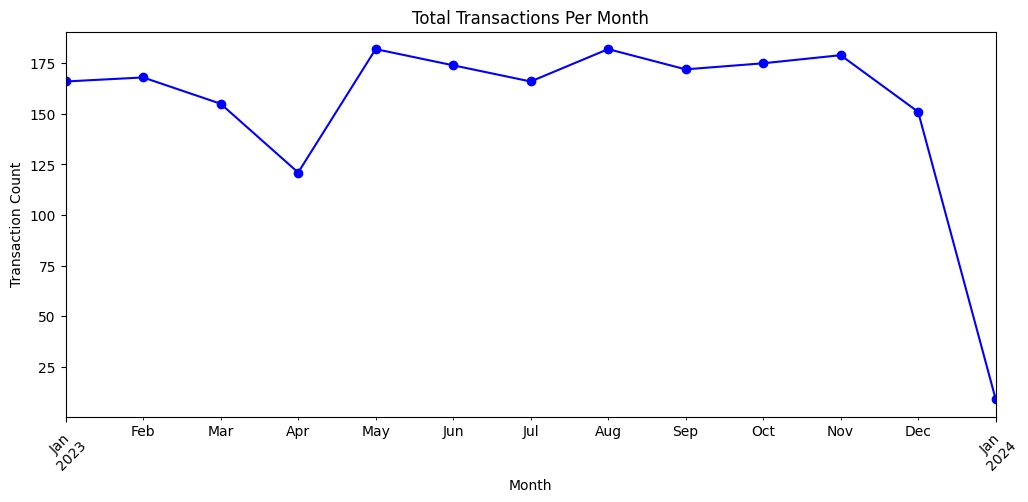

In [26]:
# Convert TransactionDate to extract time-based features
df["TransactionMonth"] = df["PreviousTransactionDate"].dt.to_period("M")


plt.figure(figsize=(12, 5))
df.groupby("TransactionMonth").size().plot(kind="line", marker="o", color="blue")
plt.title("Total Transactions Per Month")
plt.xlabel("Month")
plt.ylabel("Transaction Count")
plt.xticks(rotation=45)
plt.show()

Visualize

<ipython-input-27-152a6cc73526>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["SpendingCategory"], palette="coolwarm", ax=axes[0, 0])
<ipython-input-27-152a6cc73526>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df["MostFrequentCategory"], palette="Blues_r", ax=axes[0, 1])
<ipython-input-27-152a6cc73526>:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df["offer_accepted"], palette="viridis", ax=axes[1, 0])
<ipython-input-27-152a6cc73526>:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and

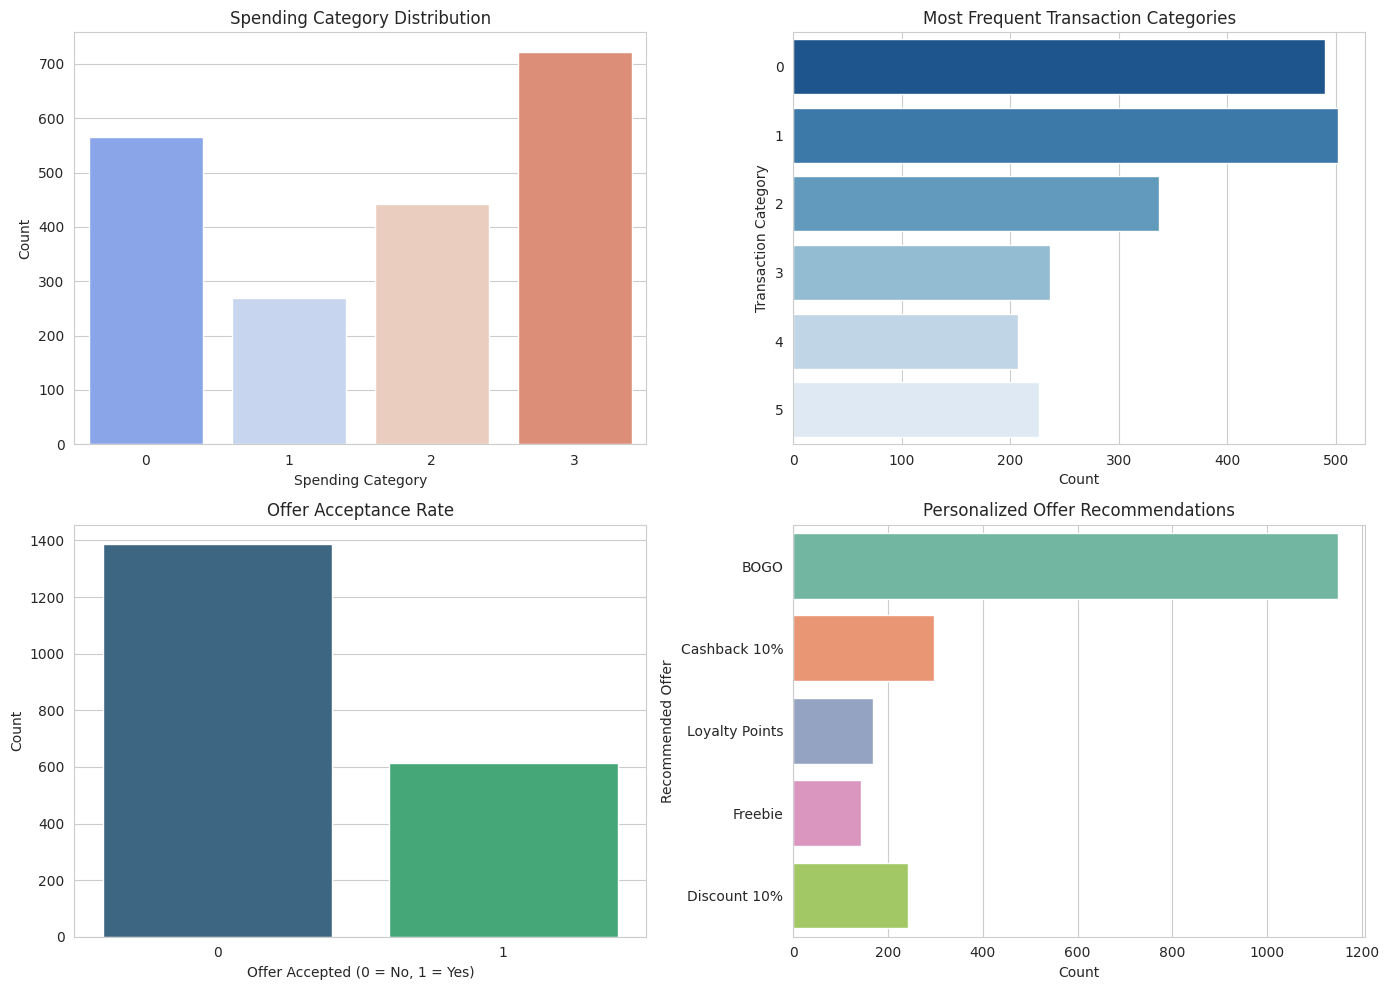

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Spending Category Distribution
sns.countplot(x=df["SpendingCategory"], palette="coolwarm", ax=axes[0, 0])
axes[0, 0].set_title("Spending Category Distribution")
axes[0, 0].set_xlabel("Spending Category")
axes[0, 0].set_ylabel("Count")

# 2. Most Frequent Transaction Categories
sns.countplot(y=df["MostFrequentCategory"], palette="Blues_r", ax=axes[0, 1])
axes[0, 1].set_title("Most Frequent Transaction Categories")
axes[0, 1].set_xlabel("Count")
axes[0, 1].set_ylabel("Transaction Category")



# 3. Offer Acceptance Rate
sns.countplot(x=df["offer_accepted"], palette="viridis", ax=axes[1, 0])
axes[1, 0].set_title("Offer Acceptance Rate")
axes[1, 0].set_xlabel("Offer Accepted (0 = No, 1 = Yes)")
axes[1, 0].set_ylabel("Count")

# 4. Personalized Offer Recommendations
df["predicted_offer"] = df.apply(recommend_offer, axis=1)
sns.countplot(y=df["predicted_offer"], palette="Set2", ax=axes[1, 1])
axes[1, 1].set_title("Personalized Offer Recommendations")
axes[1, 1].set_xlabel("Count")
axes[1, 1].set_ylabel("Recommended Offer")

plt.tight_layout()
plt.show()

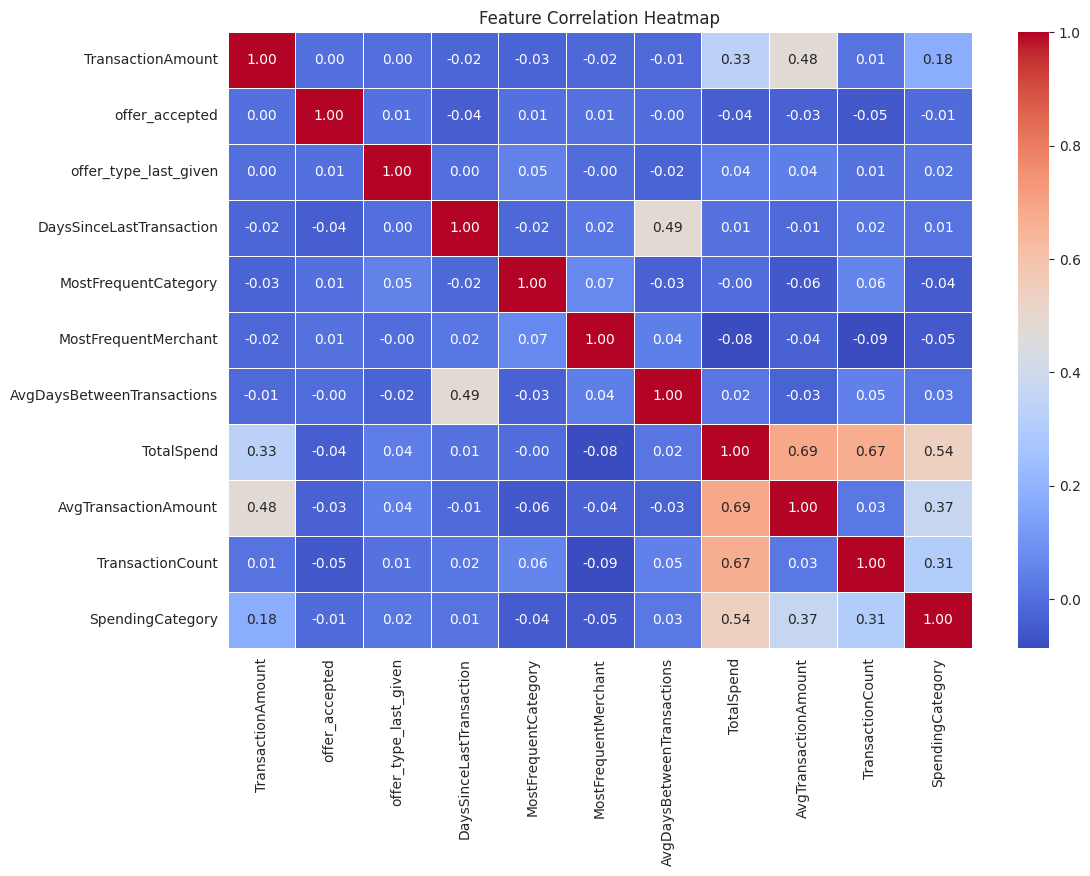

In [28]:
#Compute correlation matrix
corr_matrix = df.select_dtypes(include=["number"]).corr()

#Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()